# Finite Differences for Poisson-Problem: Rectangle and Convergence
TODO: Rewrite for rectangle
The *Finite Difference Method* (FDM) is a numerical method to solve *Partial Differential Equations* (PDEs) approximately.
## Poisson Problem
We want to solve the Poisson equation
$$
\begin{align}
  -Δ u(x,y) &= f(x,y), & (x,y) &∈ [0,L]^2 \\
  u(x,0) &= b(x), & x &∈ [0,L] \\
  u(x,L) &= t(x), & x &∈ [0,L] \\
  u(L,y) &= r(y), & y &∈ [0,L] \\
  u(0,y) &= l(y), & y &∈ [0,L] \\
\end{align}
$$
on a unit-suqare with $L=1$. The domain is discreitize uniformly with N grid-points per dimensions leading to $h=\frac{1}{N-1}$. We discreitze the Laplacian using central finite differences with second order as
$$
    Δ u(x,y) = \frac{-u(x+h,y) - u(x-h,y) + 4u(x,y) - u(x,y+h) - u(x,y-h)}{h^2} + \mathcal{O}(h^2) \\
$$
such that the stencil for node values reads
$$
\begin{align}
    u_{i,j} &≈ \frac{-u_{i+1,j} - u_{i-1,j} + 4u_{i,j} -u_{i,j+1} -u_{i,j-1}}{h^2}
    \\ ⇔
    [- Δu_h]_ξ &=
    \frac{1}{h^2}
    \begin{bmatrix}
         0 & -1 &  0 \\
        -1 &  4 & -1 \\
         0 & -1 &  0 \\
    \end{bmatrix}
    , \quad ξ ∈ Ω_h
\end{align}
$$


In [1]:
using LinearAlgebra
using SparseArrays
using Plots


## Domain and Boundary Conditions
The domain $\bar{Ω}$ $[0,L]^2$ is split into the nodes $\{(x_i,y_j)\}_{i,j=0 \dots N} ∈\bar{Ω}_h$ with
$$
    x_i = \frac{L}{N-1} ,\quad y_j = \frac{L}{N-1}
$$
The interior nodes are $\{(x_i,y_j)\}_{i,j=1 \dots N-1} ∈ Ω_h$.
We further need boundary conditions for all four sides of the unit square.


In [2]:
struct Rectangle
    Lx::Float64
    Ly::Float64
    Nx::Int64
    Ny::Int64
    hx::Float64
    hy::Float64
    xh::Array{Float64,1}
    yh::Array{Float64,1}
    function Rectangle(Lx, Ly, Nx, Ny)
        hx = Lx/(Nx-1)
        hy = Ly/(Ny-1)
        xh = range(0, Lx, step=hx)
        yh = range(0, Ly, step=hy)
        N = new(Lx, Ly, Nx, Ny, hx, hy, xh, yh)
    end
end

struct UnitSquareUniform
    function UnitSquareUniform(N)
        h = 1/(N-1)
        xh = range(0, 1, step=h)
        yh = range(0, 1, step=h)
        N = Rectangle(1., 1., N, N)
    end
end

test = UnitSquareUniform(10)
display(test)

struct RectangleBCs
    bot
    right
    top
    left
end


Rectangle(1.0, 1.0, 10, 10, 0.1111111111111111, 0.1111111111111111, [0.0, 0.1111111111111111, 0.2222222222222222, 0.3333333333333333, 0.4444444444444444, 0.5555555555555556, 0.6666666666666666, 0.7777777777777778, 0.8888888888888888, 1.0], [0.0, 0.1111111111111111, 0.2222222222222222, 0.3333333333333333, 0.4444444444444444, 0.5555555555555556, 0.6666666666666666, 0.7777777777777778, 0.8888888888888888, 1.0])

## Discretization of Poisson Problem
### TODO
- Explain Matrix structure and RHS
- Define Kronecker product and Kronecker sum


In [3]:
function Δₕ(Ω::Rectangle)
    ⊗ = kron
    dxx = spdiagm(-1=>ones(Ω.Nx-3), 0=>-2ones(Ω.Nx-2), 1=>ones(Ω.Nx-3))
    dyy = spdiagm(-1=>ones(Ω.Ny-3), 0=>-2ones(Ω.Ny-2), 1=>ones(Ω.Ny-3))
    return 1/Ω.hx^2 * I(Ω.Ny-2) ⊗ dxx + 1/Ω.hy^2 * dyy ⊗ I(Ω.Nx-2)
end

function bₕ(Ω::Rectangle, f, bcs::RectangleBCs)
    Nx = Ω.Nx
    Ny = Ω.Ny
    xInt = Ω.xh[2:end-1]
    yInt = Ω.yh[2:end-1]

    fh = vec(f.(xInt,yInt'))
    bh = 1/Ω.hy^2 .* vec(bcs.bot.(xInt))
    rh = 1/Ω.hx^2 .* vec(bcs.right.(yInt))
    th = 1/Ω.hy^2 .* vec(bcs.top.(xInt))
    lh = 1/Ω.hx^2 .* vec(bcs.left.(yInt))

    bvec = zeros((Nx-2)*(Ny-2))
    bvec += fh
    bvec[1                  : 1      : Nx-2] += bh
    bvec[(Nx-2)*(Ny-2-1)+1  : 1      : end] += th
    bvec[(Nx-2)             : (Nx-2) : end] += rh
    bvec[1                  : (Nx-2) : end] += lh

    return bvec
end

function solvePoisson(Ω::Rectangle, f, bcs::RectangleBCs)
    A = -Δₕ(Ω)
    b = bₕ(Ω, f, bcs)
    return (A) \ b
end

function plotSol(Ω::Rectangle, u, bcs::RectangleBCs, edgeAvg=true)
    pyplot()
    Nx = Ω.Nx
    Ny = Ω.Ny
    uMat = zeros(Nx,Ny)
    uMat[2:end-1,2:end-1] = reshape(u, (Nx-2, Ny-2))
    uMat[2:Nx-1,1] = vec(bcs.bot.(Ω.xh[2:end-1]))
    uMat[2:Nx-1,Ny] = vec(bcs.top.(Ω.xh[2:end-1]))
    uMat[Nx,2:Ny-1] = vec(bcs.right.(Ω.yh[2:end-1]))
    uMat[1,2:Ny-1] = vec(bcs.left.(Ω.yh[2:end-1]))
    if edgeAvg
        uMat[1,1] = 0.5 * (uMat[1,2] + uMat[2,1])
        uMat[1,Ny] = 0.5 * (uMat[1,Ny-1] + uMat[2,Ny])
        uMat[Nx,1] = 0.5 * (uMat[Nx-1,1] + uMat[Nx,2])
        uMat[Nx,Ny] = 0.5 * (uMat[Nx-1,Ny] + uMat[Nx-1,Ny])
    else
        uMat[1,1] = uMat[1,Ny] = uMat[Nx,1] = uMat[Nx,Ny] = 0
    end
    Plots.surface(Ω.xh, Ω.yh, uMat', camera=(35, 35), title="Plot")
end


plotSol (generic function with 2 methods)

## Experiments
- Show unit square from last week
- Show unit square with non-uniform discretization
- Show rectangle with non-uniform discretization


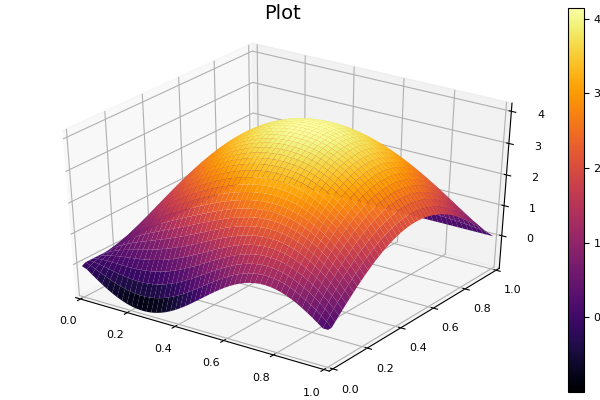

In [4]:
Ω = UnitSquareUniform(50)
bcs = RectangleBCs(x -> -sin(2pi*x), y -> 2sin(pi*y), x -> 0, y -> 0)
f(x,y) = 50
u = solvePoisson(Ω, f, bcs)
plotSol(Ω, u, bcs)


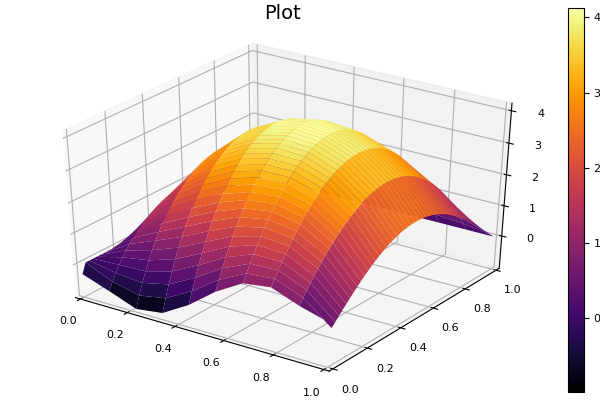

In [5]:
Ω = Rectangle(1, 1, 10, 50)
bcs = RectangleBCs(x -> -sin(2pi*x), y -> 2sin(pi*y), x -> 0, y -> 0)
f(x,y) = 50
u = solvePoisson(Ω, f, bcs)
plotSol(Ω, u, bcs)


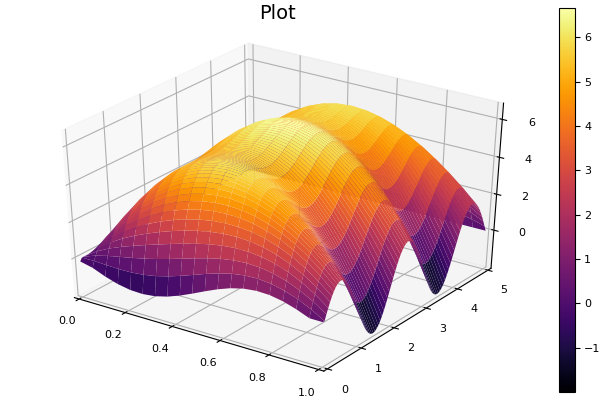

In [6]:
Ω = Rectangle(1, 5, 20, 100)
bcs = RectangleBCs(x -> -sin(2pi*x), y -> 2sin(pi*y), x -> 0, y -> 0)
f(x,y) = 50
u = solvePoisson(Ω, f, bcs)
plotSol(Ω, u, bcs)


## Convergence Properties
For convergence, we need a vanishing error $e_h = u|_{\bar{Ω}_h} - u_h$
$$
  \Vert e_h \Vert \overset{h \rightarrow 0}{→} 0
$$
This can be proven by showing stability ($\Vert Δ_h^{-1} \Vert \overset{!}{≤} C \;∀ h>0$) and consistency ($\Vert -Δ_h u|_{\bar{Ω}_h} - f|_{Ω_h} \Vert \overset{h \rightarrow 0}{→} 0$) due to
$$
  \Vert e_h \Vert ≤ \Vert Δ_h^{-1} \Vert ⋅ \Vert -Δ_h u|_{\bar{Ω}_h} - f|_{Ω_h} \Vert
$$
From the lecture, we know that (four our setup):
- ${\Vert e_h \Vert}_∞ ≤ \frac{1}{8} ⋅ \frac{C}{6} h^2$
- ${\Vert e_h \Vert}_2 ≤ \frac{1}{8} ⋅ \frac{C}{6} h$
- ${\Vert e_h \Vert}_{2,h} ≤ \frac{1}{8} ⋅ \frac{C}{6} h^2$

where ${\Vert e_h \Vert}_{2,h} = h {\Vert e_h \Vert}_{2}$. We observe this numerically.


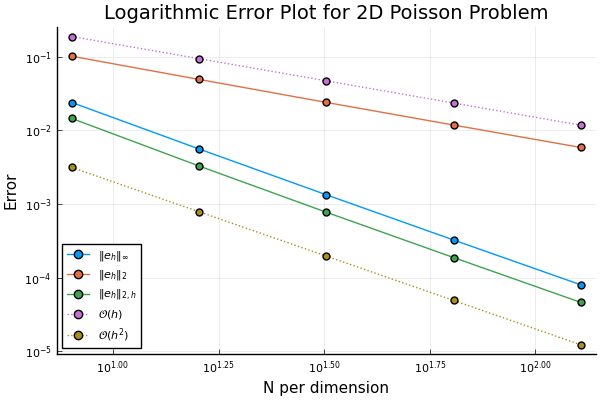

In [7]:
using Printf

errorLInfArray = Vector{Float64}()

uVecDict = Dict{Int64, Vector{Float64}}()
uRealVecDict = Dict{Int64, Vector{Float64}}()
errorVecDict = Dict{Int64, Vector{Float64}}()
ΩDict = Dict{Int64, Rectangle}()

eInfVector = Vector{Float64}()
e2Vector = Vector{Float64}()
e2hVector = Vector{Float64}()

uReal(x,y) = (cosh(2*pi*y) + ((1-cosh(2*pi))/sinh(2*pi))*sinh(2*pi*y) ) * sin(2*pi*x)

normInf(vec) = norm(vec, Inf)
norm2(vec) = norm(vec, 2)
norm2h(vec, h) = h * norm(vec, 2)

NRange = 2 .^(3:7)

for N = NRange
    Ω = UnitSquareUniform(N)
    ΩDict[N] = Ω
    bcs = RectangleBCs(x -> sin(2pi*x), y -> 0, x -> sin(2pi*x), y -> 0)
    f(x,y) = 0

    uVec = solvePoisson(Ω, f, bcs)
    uRealVec = vec(uReal.(Ω.xh[2:end-1],Ω.yh[2:end-1]'))

    uVecDict[N] = uVec
    uRealVecDict[N] = uRealVec

    errorVec = uVec - uRealVec
    errorVecDict[N] = errorVec

    append!(eInfVector,normInf(errorVec))
    append!(e2Vector,norm2(errorVec))
    append!(e2hVector,norm2h(errorVec, Ω.hx))
end

using LaTeXStrings
plot(NRange, [eInfVector, e2Vector, e2hVector, 1.5 ./NRange, 0.2 ./NRange.^2],
     label=[ L"{\Vert e_h \Vert}_{\infty}" L"{\Vert e_h \Vert}_{2}" L"{\Vert e_h \Vert}_{2,h}" L"\mathcal{O}(h)" L"\mathcal{O}(h^2)"],
     title="Logarithmic Error Plot for 2D Poisson Problem",
     xaxis=("N per dimension", :log),
     yaxis=("Error", :log),
     marker = (:circle, 5),
     line = [:solid :solid :solid :dot :dot]
 )


## Spatial Distribution of Error
Related to eigenfunctions, see later in lecture...


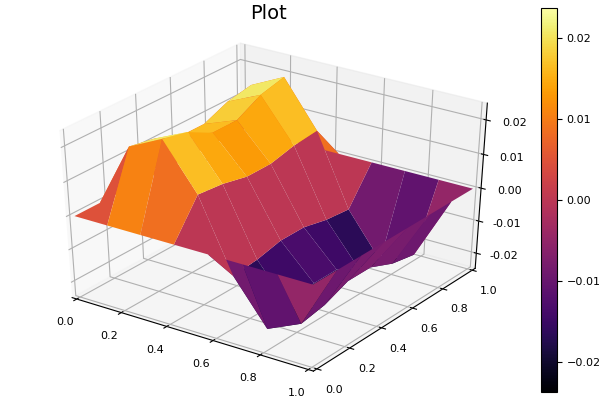

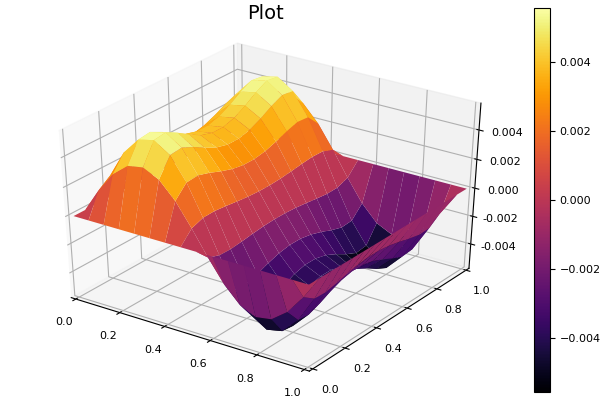

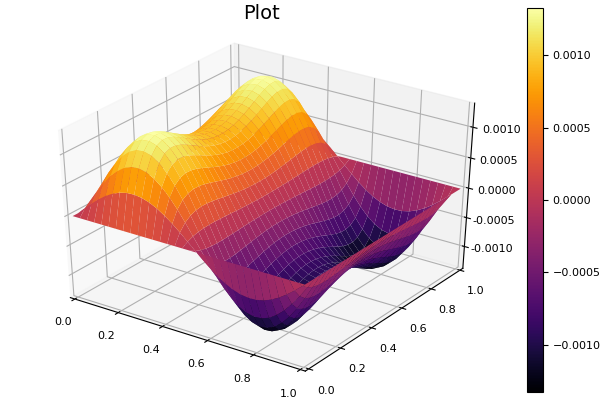

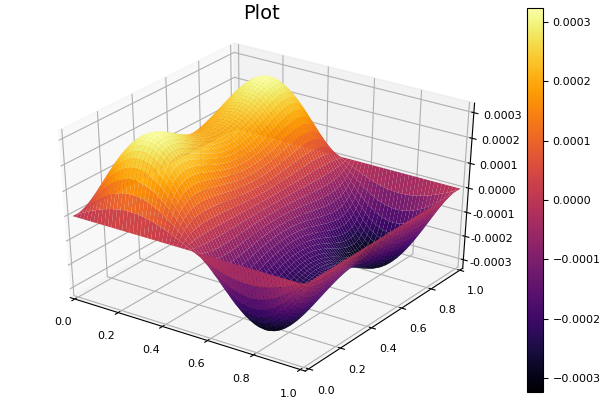

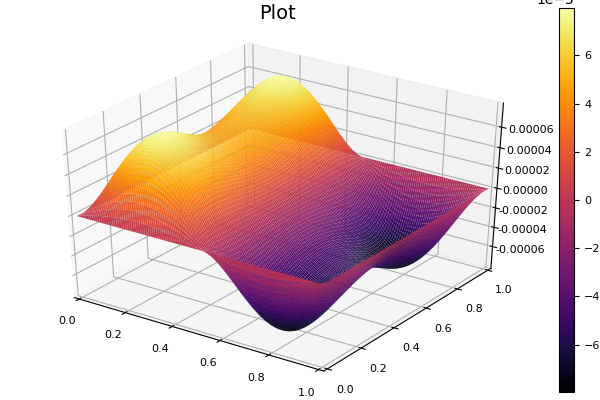

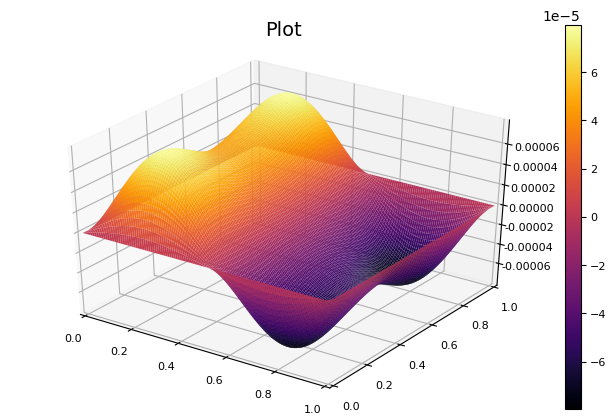

In [8]:
for N = NRange
    display(plotSol(ΩDict[N], errorVecDict[N], RectangleBCs(x->0, y->0, x->0, y->0), false))
end